# Research Project for Econometrics I
# Topic: Regression Analysis of Youth Unemployment in Kazakhstan

Two sources will be used in this project: 
* [Bureau of national statistics of the Agency for strategic planning and reforms of the Republic of Kazakhstan](https://www.stat.gov.kz/) 
* [World Bank Open Data](https://data.worldbank.org/)

**Variables used in the regression**:

**Target variable**: Youth unemployment rate across regions of Kazakhstan. 

**Independent variables**: 
* Share of population below subsistance level 
* GDP growth 
* Log of GRP 
* Gross Savings (as a % of overall GDP) 
* Spending on Education (as a % of overall GDP) 
* Consumer Price Index 

## Importing and Data Preparation

### Steps
* Import dataframes 
* Replace time index values for the last day of the year in years between 2001 and 2021:
    - This is done because python, when converting year column to DateTimeIndex, creates indices of the first day of the year, which is incorrect, as yearly values are published after the year is finished.  
* Check and replace NaN values
* Convertion from wide dataframe into long dataframe
* Merging dataframes into one final dataframe 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import youth unemployment rate

unemp_rate = pd.read_excel('data/youth_unemp.xlsx', na_values='-', index_col=0)

In [3]:
# import share of population below subsistance level

below_level = pd.read_excel('data/Share of the population below subsistance level.xlsx', na_values='-', index_col=0, parse_dates=True)

In [4]:
# import Gross Regional Product (mln tenge)

grp = pd.read_excel('data/GRP.xlsx', na_values='-', header=0, 
                   index_col=0, parse_dates=True)
grp = np.log(grp)

In [5]:
# import annual GDP growth

from pandas_datareader import wb
gdp = wb.download(indicator = 'NY.GDP.MKTP.KD.ZG', country='KZ', start = 2001, end=2021)

gdp.reset_index(inplace = True)
gdp.drop('country', axis=1, inplace=True)
gdp.rename({'NY.GDP.MKTP.KD.ZG': 'GDP Growth'}, axis=1, inplace=True)
gdp = gdp.astype({'GDP Growth': 'float'})
gdp = gdp.sort_values('year', ascending=True)
gdp.drop(['year'], axis=1, inplace=True)

In [6]:
# import Gross savings

savings = wb.download(indicator = 'NY.GNS.ICTR.ZS', country='KZ', start = 2001, end=2021) 
savings.reset_index(inplace = True)
savings.drop('country', axis=1, inplace=True)
savings.rename({'NY.GNS.ICTR.ZS': 'Gross savings (% of GDP)'}, axis=1, inplace=True)
savings = savings.astype({'Gross savings (% of GDP)': 'float'})
savings = savings.sort_values('year', ascending=True)
savings.drop(['year'], axis=1, inplace=True)

In [7]:
# import CPI (2010=100)

cpi = wb.download(indicator = 'FP.CPI.TOTL', country='KZ', start = 2001, end=2021) 
cpi.reset_index(inplace = True)
cpi.drop('country', axis=1, inplace=True)
cpi.rename({'FP.CPI.TOTL': 'CPI'}, axis=1, inplace=True)
cpi = cpi.astype({'CPI': 'float'})
cpi = cpi.sort_values('year', ascending=True)
cpi.drop(['year'], axis=1, inplace=True)

In [8]:
# import expenditure on education (% of GDP)

education = wb.download(indicator = 'SE.XPD.TOTL.GD.ZS', country='KZ', start = 2001, end=2021) 
education.reset_index(inplace = True)
education.drop('country', axis=1, inplace=True)
education.rename({'SE.XPD.TOTL.GD.ZS': 'Education Spending (% of GDP)'}, axis=1, inplace=True)
education = education.astype({'Education Spending (% of GDP)': 'float'})
education = education.sort_values('year', ascending=True)
education.drop(['year'], axis=1, inplace=True)

In [9]:
# setting index values for each dataframe

years = pd.date_range(start='2001', periods=21, freq='Y')

for df in unemp_rate, below_level, grp, gdp, savings, cpi, education:
    df.set_index(years, inplace=True)

In [10]:
# checking the null values in the dataframes

list_of_dfs = [unemp_rate, below_level, grp, gdp, savings, cpi, education]

for df in list_of_dfs:
    null_status = df.isnull().values.any()
    if null_status:
        print(df[df.isnull().any(axis=1)], '\n')

            Gross savings (% of GDP)
2021-12-31                       NaN 

            CPI
2021-12-31  NaN 

            Education Spending (% of GDP)
2001-12-31                            NaN
2003-12-31                            NaN
2020-12-31                            NaN
2021-12-31                            NaN 



We see that we have one missing value in Gross Savings and CPI dataframes, and four missing values in Education Spending dataframe.

Instead of filling the NaN values with pandas methods, I extracted data from the Bureau of National Statistics of Kazakhstan by using the same calculation methods that the World Bank uses. 

In [11]:
# Replaced Nan Values with data taken from Bureau of National Statistics of Kazakhstan

education.loc['2001-12-31']['Education Spending (% of GDP)'] = 0.039
education.loc['2003-12-31']['Education Spending (% of GDP)'] = 0.035
education.loc['2020-12-31']['Education Spending (% of GDP)'] = 3.6
education.loc['2021-12-31']['Education Spending (% of GDP)'] = 3.9

savings.loc['2021-12-31']['Gross savings (% of GDP)'] = 36.7

cpi.loc['2021-12-31']['CPI'] = 218.5

In [12]:
# concatenating "World Bank" determinants together

determinants = pd.concat([gdp, cpi, education, savings], axis=1, verify_integrity=True)
determinants.reset_index(inplace=True)

In [13]:
# melting (transforming) wide panel data into long panel data for regression 

region_names = list(unemp_rate.columns) #extracting region names for melting
region_names

unemp_rate.reset_index(inplace=True)
unemp_rate = pd.melt(unemp_rate, id_vars=['index'], value_vars=region_names, var_name='Region', value_name='Youth Unemployment Rate')

below_level.reset_index(inplace=True)
below_level = pd.melt(below_level, id_vars=['index'], value_vars=region_names, var_name='Region', value_name='Population below subsistance level (%)')

grp.reset_index(inplace=True)
grp = pd.melt(grp, id_vars=['index'], value_vars=region_names, var_name='Region', value_name="Log of GRP")


In [14]:
# Merging all dataframes 

temp = pd.merge(pd.merge(unemp_rate, below_level, on=['index', 'Region'], how='outer'), grp, on=['index', 'Region'], how='outer')
final_df = temp.merge(determinants, on='index', how='outer')
final_df.rename(columns={'index':'Year'}, inplace=True)

### Final Dataset


In [15]:
final_df

,Year,Region,Youth Unemployment Rate,Population below subsistance level (%),Log of GRP,GDP Growth,CPI,Education Spending (% of GDP),Gross savings (% of GDP)
0,2001-12-31,Republic of Kazakhstan,16.563255,46.7,14.994348,13.5,47.447524,0.039,24.809925
1,2001-12-31,Akmola,16.784240,42.9,11.587037,13.5,47.447524,0.039,24.809925
2,2001-12-31,Aktobe,17.324236,41.4,11.898495,13.5,47.447524,0.039,24.809925
3,2001-12-31,Almaty,14.794314,61.1,11.974729,13.5,47.447524,0.039,24.809925
4,2001-12-31,Atyrau,21.194063,56.4,12.589309,13.5,47.447524,0.039,24.809925
...,...,...,...,...,...,...,...,...,...
352,2021-12-31,Pavlodar,2.800000,3.9,15.172331,4.0,218.500000,3.900,36.700000
353,2021-12-31,North Kazakhstan,2.900000,5.5,14.398156,4.0,218.500000,3.900,36.700000
354,2021-12-31,East Kazakhstan,3.000000,5.5,15.437600,4.0,218.500000,3.900,36.700000
355,2021-12-31,Nur-Sultan city,4.600000,2.2,16.004223,4.0,218.500000,3.900,36.700000


In the final dataset, we have all the variables (including our target variable). Note that in the region, we have rows for "Republic of Kazakhstan". These rows represent aggregated data for the "whole country", along with data for each region. Later, I split the dataset into two: one for "Republic of Kazakhstan" only, and one that includes only the regions of Kazakhstan.

## Data Exploration

In [16]:
# dataframe for the whole country

final_df_kz = final_df[final_df['Region'] == 'Republic of Kazakhstan'].drop(columns={'Region'})

# dataframe for the regions

final_df = final_df[final_df['Region'] != 'Republic of Kazakhstan']

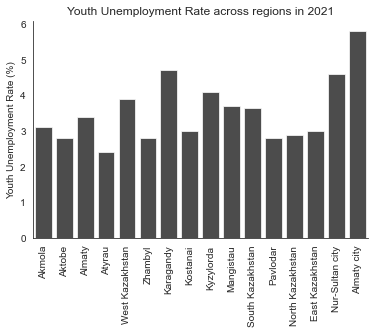

In [17]:
# Plot of barplot of target variable (Youth unemployment level) for the last year (2021)

sns.set_style("white")
sns.barplot(data=final_df[final_df['Year'] == '2021-12-31'], x='Region', y='Youth Unemployment Rate', alpha=0.7, color='k')

plt.title('Youth Unemployment Rate across regions in 2021')
plt.xlabel(None)
plt.xticks(rotation=90)
plt.ylabel('Youth Unemployment Rate (%)')
sns.despine(right=True, top=True)

plt.savefig("youth_unemp_2021.png", bbox_inches='tight', dpi=600)
plt.show()

**Observations**:

* In 2021, the highest unemployment rate was observed in Almaty city: almost 6% 
* Second highest unemployment rate belongs to Karagandy region, with the value of nearly 4.8% 
* The lowest was in Atyrau region: about 2.5%

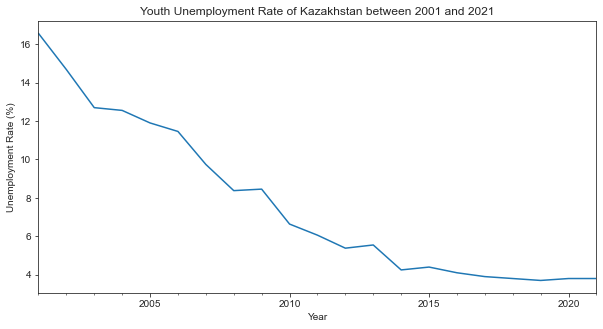

In [18]:
# Plot of time series of target variable (Youth unemployment level)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
sns.set_style("ticks")

final_df_kz.plot(x='Year', y='Youth Unemployment Rate', kind='line', legend=None)

plt.title('Youth Unemployment Rate of Kazakhstan between 2001 and 2021')
plt.ylabel('Unemployment Rate (%)')

plt.savefig("youth_unemp.png", bbox_inches='tight', dpi=600)
plt.show()

Overall, there has been a steady decrease in the youth unemployment rate of Kazakhstan until around 2019, with little spikes in 2004, 2006, 2009 and 2013. Between 2019 and 2021, the rate was constant. Compared to the value in 2001 (a little over 16%), the youth unemployment rate has decreased by almost 4 times in 2021.

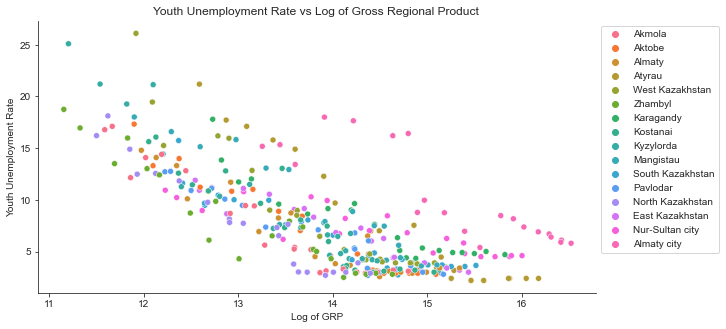

In [19]:
# Youth Unemployment Rate vs Log of Gross Regional Product

palette = sns.color_palette("husl", 16)
sns.scatterplot(data = final_df, y='Youth Unemployment Rate', x='Log of GRP', hue='Region', palette=palette).set(title=                
                'Youth Unemployment Rate vs Log of Gross Regional Product ')
 
sns.despine(right=True, top=True)
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1), title=None)

plt.savefig("unemp_grp.png", bbox_inches='tight', dpi=600)
plt.show()

Overall, we notice negative relationship between Log of GRP and Youth Unemployment Rate, and the relationship seems to be linear. 

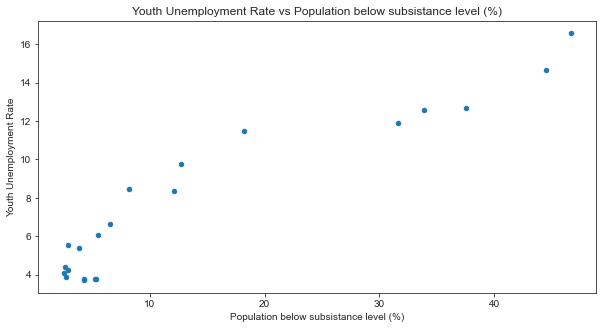

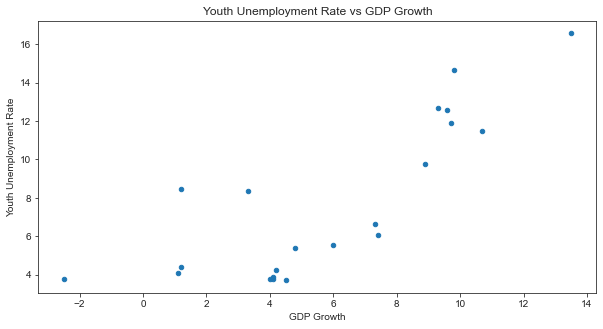

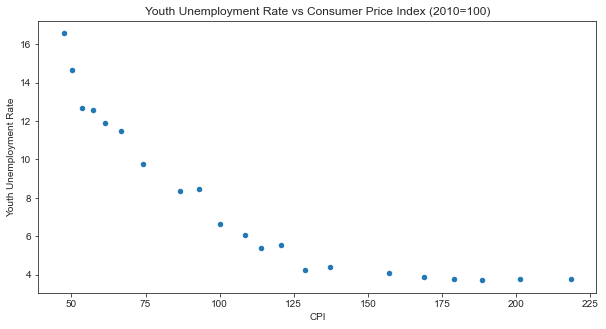

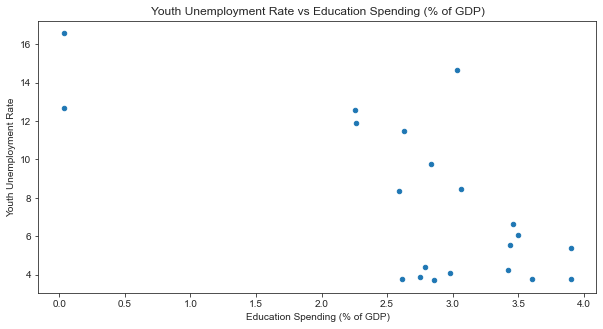

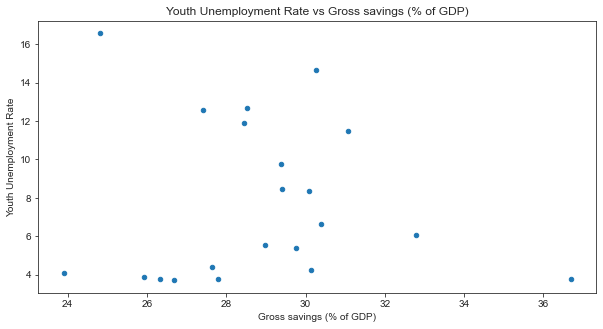

In [20]:
# Relationship between macro determinants

final_df_kz.plot(kind='scatter', y='Youth Unemployment Rate', x='Population below subsistance level (%)', title = 'Youth Unemployment Rate vs Population below subsistance level (%)', legend=False)
plt.savefig("population_below.png", bbox_inches='tight', dpi=600)

final_df_kz.plot(kind='scatter', y='Youth Unemployment Rate', x='GDP Growth', title='Youth Unemployment Rate vs GDP Growth', legend=False)
plt.savefig("gdp_growth.png", bbox_inches='tight', dpi=600)

final_df_kz.plot(kind='scatter', y='Youth Unemployment Rate', x='CPI', title='Youth Unemployment Rate vs Consumer Price Index (2010=100)', legend=False)
plt.savefig("cpi.png", bbox_inches='tight', dpi=600)

final_df_kz.plot(kind='scatter', y='Youth Unemployment Rate', x='Education Spending (% of GDP)', title='Youth Unemployment Rate vs Education Spending (% of GDP)', legend=False)
plt.savefig("educ_spending.png", bbox_inches='tight', dpi=600)

final_df_kz.plot(kind='scatter', y='Youth Unemployment Rate', x='Gross savings (% of GDP)', title='Youth Unemployment Rate vs Gross savings (% of GDP)', legend=False)
plt.savefig("savings.png", bbox_inches='tight', dpi=600)

plt.show()

## Multilinear regression model

In [21]:
# setting year and region as indices for Fixed Effect model

final_df.set_index(['Region', 'Year'], inplace=True)

In [22]:
X = final_df.drop('Youth Unemployment Rate', axis=1)
y = final_df['Youth Unemployment Rate']

### Pooled Linear Regression

In [23]:
import statsmodels.api as sm
from linearmodels import PooledOLS

exog = sm.add_constant(X)
model_pooled = PooledOLS(y, exog).fit(cov_type='clustered', cluster_entity=True)
print(model_pooled)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = model_pooled.predict().fitted_values
residuals_pooled_OLS = model_pooled.resids

                             PooledOLS Estimation Summary                            
Dep. Variable:     Youth Unemployment Rate   R-squared:                        0.8133
Estimator:                       PooledOLS   R-squared (Between):             -0.1661
No. Observations:                      336   R-squared (Within):               0.8593
Date:                     Tue, Nov 29 2022   R-squared (Overall):              0.8133
Time:                             00:46:51   Log-likelihood                   -715.23
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      238.88
Entities:                               16   P-value                           0.0000
Avg Obs:                            21.000   Distribution:                   F(6,329)
Min Obs:                            21.000                                           
Max Obs:                            21.000   F-statist

### Homoskedasticity

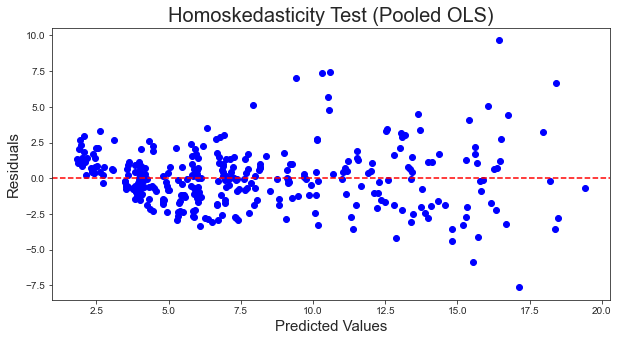

In [24]:
# Source: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

# Homoskedasticity
# Residuals-Plot 
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test (Pooled OLS)', fontsize = 20)
plt.savefig("homoskedasticity_pooled_ols.png", bbox_inches='tight', dpi=600)
plt.show()

In [25]:
# White-Test for homoskedasticity

from statsmodels.stats.diagnostic import het_white

pooled_OLS_dataset = pd.concat([X, residuals_pooled_OLS], axis=1)

exog = sm.add_constant(X).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

{'LM-Stat': 78.73695164442881, 'LM p-val': 5.859261039408137e-07, 'F-Stat': 3.4913077924192493, 'F p-val': 5.4412094919594714e-08}


The p-value is less than 0.05: heteroskedasticity is indicated.

### Autocorrelation

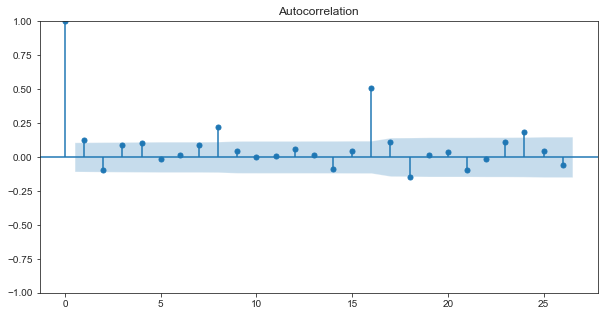

In [26]:
# Autocorrelation Plot
import statsmodels.graphics.tsaplots as tsap

tsap.plot_acf(x=residuals_pooled_OLS)
plt.show()

We notice statistically significant auto-correlation at lag 8 and 16.

In [27]:
# Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

1.7395139537184066


The Durbin-Watson-Test result showed a value of 1.74, indicating relatively weak and positive autocorrelation. 

### Multicollinearity

Let's run the Variable Inflation Factors to assess the multicollinearity.

In [28]:
# VIF test for the whole country

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(exog.values, i) for i in range(exog.values.shape[1])]
vif["features"] = exog.columns
vif

,VIF Factor,features
0,671.877731,const
1,2.953905,Population below subsistance level (%)
2,4.188673,Log of GRP
3,3.085399,GDP Growth
4,3.794514,CPI
5,2.566626,Education Spending (% of GDP)
6,1.563597,Gross savings (% of GDP)


**Summary of findings with Pooled OLS**:
- $R^2$ is 0.81, meaning that 81% of the variation in youth unemployment rate is explained by the variation of in the independent variables. This value is pretty good.
- The model violates the assumption of homoskedasticity and autocorrelation. 
- The VIF test shows no signs of strong multicollinearity between the variables.
- To address the violations, I will build Fixed Effects OLS model.


### Region Fixed Effects OLS regression

In [29]:
from linearmodels.panel import PanelOLS

exog = sm.add_constant(X)
model_fe = PanelOLS(y, exog, entity_effects=True).fit(cov_type="clustered", cluster_entity=True)
print(model_fe)

                             PanelOLS Estimation Summary                             
Dep. Variable:     Youth Unemployment Rate   R-squared:                        0.8766
Estimator:                        PanelOLS   R-squared (Between):             -2.7516
No. Observations:                      336   R-squared (Within):               0.8766
Date:                     Tue, Nov 29 2022   R-squared (Overall):              0.7139
Time:                             00:46:52   Log-likelihood                   -637.91
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      371.91
Entities:                               16   P-value                           0.0000
Avg Obs:                            21.000   Distribution:                   F(6,314)
Min Obs:                            21.000                                           
Max Obs:                            21.000   F-statist

**Key observations:**
- After running the Fixed Effects Model, $R^2$ increased by 6%
- Log of GRP became statistically significant under 5% test
- However, CPI, Education Spending and Gross savings became statistically insignificant.
    - The reason could be the lack of variance of these variables among different regions of Kazakhstan. Recall that these are macro determinants and the dataset does not contain values of these determinants for each region but rather the whole country. 


In [30]:
from linearmodels.panel import compare

print(compare({"Pooled OLS": model_pooled, "Fixed Effects": model_fe}, stars = True))

                                         Model Comparison                                         
                                                            Pooled OLS               Fixed Effects
--------------------------------------------------------------------------------------------------
Dep. Variable                                  Youth Unemployment Rate     Youth Unemployment Rate
Estimator                                                    PooledOLS                    PanelOLS
No. Observations                                                   336                         336
Cov. Est.                                                    Clustered                   Clustered
R-squared                                                       0.8133                      0.8766
R-Squared (Within)                                              0.8593                      0.8766
R-Squared (Between)                                            -0.1661                     -2.7516
R-Squared 